# Lower Confidence Bound

This section implements lower confidence bounds where the next infill point is obtained by solving a minimization problem given as:

$$
    \min_{x} \quad \hat{y}(x) - A \hat{\sigma}(x)
$$

where $\hat{y}(x)$ is the predicted value of the objective function, $\hat{\sigma}(x)$ is the predicted standard deviation (uncertainty), and $A$ is a constant. The constant $A$ is used to control the trade-off between exploration and exploitation. The larger the value of $A$, more the algorithm will explore the search space. The smaller the value of $A$, more the algorithm will exploit the current best solution. The value of $A$ is usually set to 2 or 3. Below code imports required packages, defines modified branin function, and creates plotting data:

In [28]:
# Imports
import numpy as np
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)

    y = a * (x2 - b*x1**2 + c*x1 - r)**2 + s*(1-t)*np.cos(x1) + s + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] )) 
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)

Differential evolution (DE) from `pymoo` is used for minimizing the surrogate model. Below code defines problem class and initializes DE. Note how problem class is using both prediction and uncertainty together.

In [29]:
# Problem class
class Surrogate(Problem):

    def __init__(self, sm):
        super().__init__(n_var=2, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model

    def _evaluate(self, x, out, *args, **kwargs):

        A = 3
        out["F"] = self.sm.predict_values(x) - A * np.sqrt(self.sm.predict_variances(x)) # Standard deviation

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

Below block of code creates 5 training points and performs the exploration process. The maximum number of iterations is set to 15 and a convergence criterion is defined based on the change in true function value for infill points between two consecutive iterations.

In [30]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)

# Variables
itr = 0
max_itr = 15
tol = 1e-3
error = 1
criteria = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < error:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    print(sm.optimal_theta)

    # Find the minimum of surrogate model
    result = minimize(Surrogate(sm), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))
    
    if itr == 0:
        prev = y_infill
    else:
        error = np.abs(y_infill - prev)/np.abs(y_infill)
        prev = result.F
        criteria.append(error)
    
        print("Error: {}".format(error))

    print("f*: {}".format(y_infill))
    print("x*: {}".format(result.X))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number


Iteration 1
[0.63426987 0.34488646]
f*: [283.12909601]
x*: [-5.00000000e+00  1.54201883e-16]

Iteration 2
[1.12027553e-04 1.90143653e+01]
Error: [1.68093425]
f*: [105.60836992]
x*: [10.         10.32861216]

Iteration 3
[3.74552146e-04 2.82492093e+01]
Error: [5.29840803]
f*: [53.8450763]
x*: [10.          4.38206343]

Iteration 4
[0.2182809  5.34257321]
Error: [4.98475834]
f*: [44.75281632]
x*: [-5.          9.63560114]

Iteration 5
[1.35282804 0.20252813]
Error: [24.28291219]
f*: [-7.49170048]
x*: [-5. 15.]

Iteration 6
[1.19303691 0.20059235]
Error: [5.07482831]
f*: [38.00923908]
x*: [-1.63069391 15.        ]

Iteration 7
[1.20372109 0.27891243]
Error: [5.57696698]
f*: [21.89533801]
x*: [-0.16317065  8.062195  ]

Iteration 8
[1.30497727 0.22233226]
Error: [4.77690341]
f*: [23.67071311]
x*: [2.37274552e+00 1.42609851e-15]

Iteration 9
[1.05566586 0.21937857]
Error: [2.42795483]
f*: [60.96088904]
x*: [1.00000000e+01 5.04594514e-16]

Iteration 10
[1.18925064 0.23633935]
Error: [5.02515

Below block of code plots the convergence of lower confidence bound process and infill points.

Text(0.5, 1.0, 'Modified Branin function')

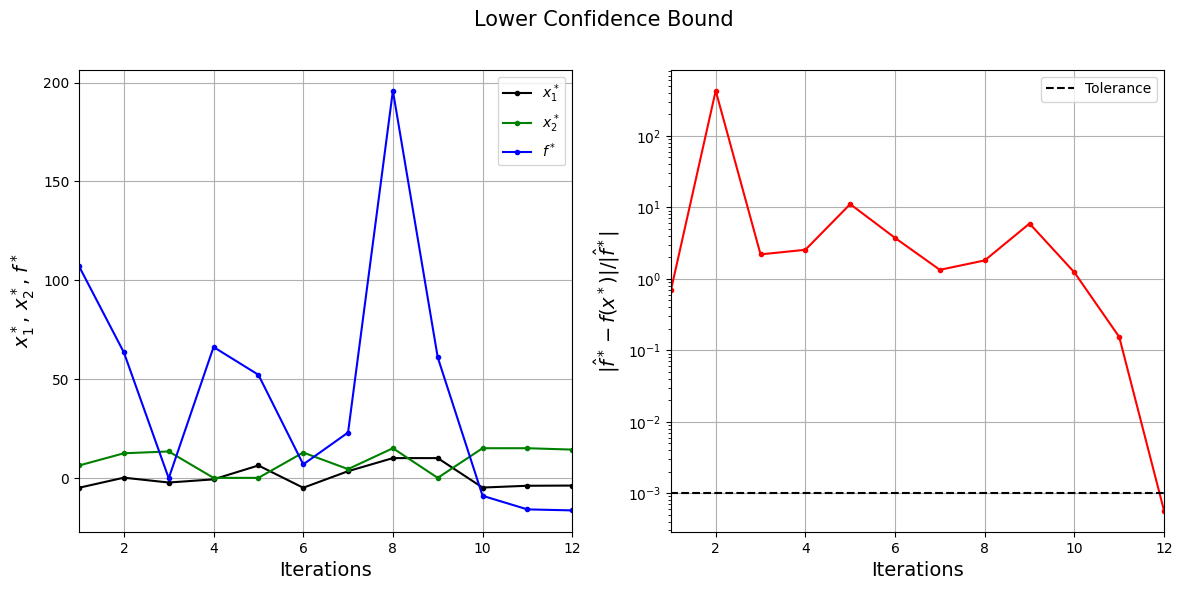

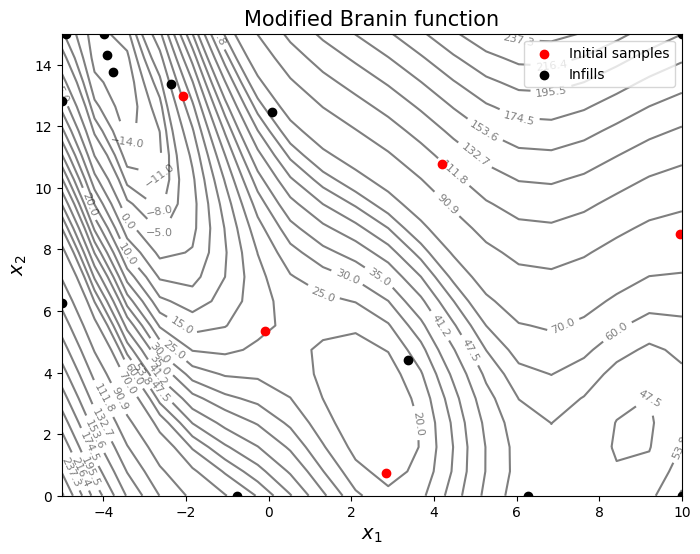

In [27]:
####################################### Plotting convergence history

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,0], c="black", label='$x_1^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, xtrain[num_train:,1], c="green", label='$x_2^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, ytrain[num_train:], c="blue", label='$f^*$', marker=".")
ax[0].set_xlabel("Iterations", fontsize=14)
ax[0].set_ylabel("$x_1^*$, $x_2^*$, $f^*$", fontsize=14)
ax[0].legend()
ax[0].set_xlim(left=1, right=itr-1)
ax[0].grid()

ax[1].plot(np.arange(itr-1) + 1, criteria, c="red", marker=".")
ax[1].plot(np.arange(itr), [tol]*(itr), c="black", linestyle="--", label="Tolerance")
ax[1].set_xlabel("Iterations", fontsize=14)
ax[1].set_ylabel(r"$| \hat{f}^* - f(x^*) | / | \hat{f}^* |$", fontsize=14)
ax[1].set_xlim(left=1, right=itr-1)
ax[1].grid()
ax[1].legend()
ax[1].set_yscale("log")

fig.suptitle("Lower Confidence Bound".format(itr), fontsize=15)

####################################### Plotting initial samples and infills

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.legend()
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Modified Branin function", fontsize=15)

The process stopped before maximum number of iterations since the convergence criteria is met. Note that some infills are used for exploration and some are used for exploitation. As discussed in lecture, it is hard to know what value of $A$ to use. You can change the value of $A$ and see how it changes the infill location.